# 📝 Custom NER for Molecular Dynamics (MD) with spaCy v3

## Annotations of our textual molecular dynamics data

The creation of a NER requires a careful learning step. This step consists of annotating our textual data. Here we choose 5 names of annotations classes. The first is the temperature of our system, the second is the type of software, the third is the simulation time, the fourth is the model used to configure our simulation as the force field and the last one corresponds to the molecules included in the system. For that, we will use [NER Annotator for Spacy](https://tecoholic.github.io/ner-annotator/) which allows us to facilitate the creation of our training data. The annotated data will be in `.json` format. Here is an example of the annotations:

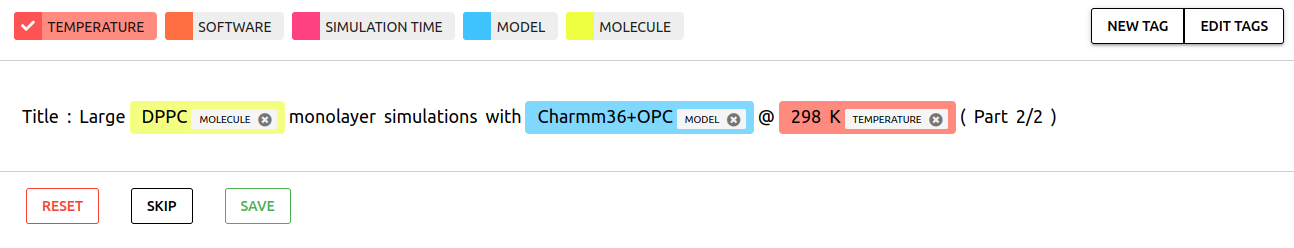

## Prerequise packages

In [1]:
import os
import json
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy import displacy

## Create a train data and validation data

For our training data, we use 10 texts containing a title and a description from a data warehouse such as [zenodo](https://zenodo.org/). These texts were chosen according to their length and whether they were enriched with information. We do the same for our validation data but only with 3 texts. The data is loaded as follows : 

In [2]:
f = open("../annotations_train.json", "r")
# Load our json file
TRAIN_DATA = json.load(f)
f.close()
f = open("../annotations_dev.json", "r")
DEV_DATA = json.load(f)
TRAIN_DATA["annotations"][1]
DEV_DATA["annotations"][1]

['Classical molecular dynamics simulations of a POPC lipid bilayer in water solution with various molar fractions of cationic surfactant dihexadecylammonium using ECC-POPC force field parameters, SPC/E water model and ECC-ions. Simulation at pure water is in a separate Zenodo deposit https://doi.org/10.5281/zenodo.1118266 file names report molar fraction of cations (i.e. not bulk concentrations) simulations performed with Gromacs 5.1.4 (.xtc files) and openMM 7 (.dcd files) simulation length 200 ns temperature 313 K (otherwise noted)',
 {'entities': [[46, 56, 'MOLECULE'],
   [135, 154, 'MOLECULE'],
   [161, 169, 'FORCE FIELD'],
   [194, 205, 'MODEL'],
   [424, 437, 'SOFTWARE'],
   [455, 463, 'SOFTWARE'],
   [495, 501, 'SIMULATION TIME'],
   [514, 519, 'TEMPERATURE']]}]

Here the variable `DEV_DATA` contains the names of the different annotation classes, the original text and the positions of the annotated strings. For example, the characters between 46 and 56 correspond to a molecule.

## Create a spaCy object

Since Spacy v3.1, training a NER requires the data to be stored as a `.spacy` binary object. Here is one way to do this from our variable `TRAIN_DATA` and `DEV_DATA`.

In [3]:
def create_spacy_object(data, file_name) :
    nlp = spacy.blank("en")  # load a new spacy model
    db = DocBin()  # create a DocBin object
    # data in previous format
    for text, annot in tqdm(data["annotations"]):
        doc = nlp.make_doc(text)  # create doc object from text
        ents = []
        for start, end, label in annot["entities"]:  # add character indexes
            span = doc.char_span(start, end, label=label,
                             alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents  # label the text with the ents
        db.add(doc)
    
    db.to_disk("./" + file_name + ".spacy")

create_spacy_object(TRAIN_DATA, "train")
create_spacy_object(DEV_DATA, "dev")

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 503.05it/s]


## Create a config file

It's necessary to configure its pipeline directly via a `config.cfg` file since the 3.1. This file will contain all the parameters and hyperparameters of our NER. It's recommended to use it because it allows a faster training and evaluation, especially during the validation stage. You can create your own config file [here](https://spacy.io/usage/training#config) and typing this command line :

In [4]:
os.system("python -m spacy init fill-config base_config.cfg config.cfg")

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


0

You can also create a configuration directly by typing this command line : 

In [5]:
os.system("python -m spacy init config config.cfg --lang en --pipeline ner --optimize efficiency --force")

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


0

Here we have chosen to create a NER by adding `--pipeline ner` where the text is in English by adding `--lang en` and we want a ner where the efficiency is optimised by adding `--optimize efficiency`. Depending on what we want, there are other parameters that influence our NER. The `--force` option specifies to force the creation of the file even if one exists.

## Train the model

With our three files it's possible to train our model. Normally it's necessary to have three files where the third one corresponds to the validation data set.

In [5]:
os.system("python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./dev.spacy")

[2023-03-03 10:07:00,258] [INFO] Set up nlp object from config
[2023-03-03 10:07:00,279] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-03-03 10:07:00,284] [INFO] Created vocabulary
[2023-03-03 10:07:00,286] [INFO] Finished initializing nlp object
[2023-03-03 10:07:00,543] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    111.50    0.00    0.00    0.00    0.00
 17     200      16024.36   3857.33   53.93   55.81   52.17    0.54
 35     400        472.66    130.16   52.87   56.10   50.00    0.53
 54     600       6484.73    112.16   52.75   53.33   52.17    0.53
 74     800          8.76      5.78   54.55   57.14   52.17    0.55
 95    1000         28.50     10.46   56.18   58.14   54.35    0.56
116    1200         43.77     15.50   45.78   51.35   41.30    0.46
138    1400         98.10     21.35   53.49   57.50   50.00    0.53
161    1600       1877.69     67.30 

0

Here we just need to specify the configuration file, the path to the output folder that will contain our model by adding `--output ./`, the path to the spacy object corresponding to our training data by adding `--paths.train ./train.spacy` and the path to the spacy object corresponding to our validation data (not really) by adding `--paths.dev ./train.spacy`. 

The output of the command allows to interpret the different models obtained with the help of the different parameters displayed, namely the loss value of the model (LOSS), the number of epochs (E), the batch size (#), the learning rate and different other parameters.

At the end of the execution, two folders will be created:
* `model-best` contains the best model among all the models built.
* `model-last` corresponds to the last models obtained.

## Use the model to annotate

In [6]:
# Load our model
nlp_ner = spacy.load("./model-last")
# Text processing by our NER
doc = nlp_ner("""
Title: CHARMM36 DOPS simulations (versions 1 and 2) 303 K 1.0 nm LJ switching
Description:
CHARMM36 DOPS simulations (303 K, starting structure from the CHARMM-GUI) performed with a 1.0 nm point at which to switch off the van der Waals interactions. Two different simulations generated with different starting velocities are provided (the files are named v1 and v2 for these different simulations). The trajectories contain only the data from 400-500 ns of the simulations (as per the analysis provided on the nmrlipids blog) and additionally they have been processed with trjconv -skip 10 to keep the upload small.
""")
doc = nlp_ner("""
Title: Simulation CER160_50_POPC_512_NaCl_150mM_310K (rep2)
Description:
Title publication: A Ceramide-Regulated Element in the Late Endosomal Protein LAPTM4B Controls Amino Acid Transporter Interaction Year publication: 2018 DOI publication: XXXXX Description: Simulation POPC membrane containing ~8% ceramide (CER160) using charmm36 at 310K. MD engine: Gromacs 2016.2-dev-20170105-4feb0be Force field: charmm36 Temperature: 310 K Pressure: 1 bar Simulation time: 3496 ns Saving frequency: 100 ps Molecular content: POPC        512 CER160      50 SOL      28100 NA              75 CL              75
""")
colors = {
    "TEMPERATURE": "#FF0000",
    "SOFTWARE": "#FFA500",
    "SIMULATION TIME": "#FD6C9E",
    "MODEL": "#00FFFF",
    "MOLECULE": "#FFFF00",
}
options = {"ents": [
    "TEMPERATURE",
    "SOFTWARE",
    "SIMULATION TIME",
    "MODEL",
    "MOLECULE"
],
    "colors": colors
}
# Display of the text annotated by our NER
spacy.displacy.render(doc, style="ent", jupyter=True, options=options)

## Display your JSON file

In [7]:
colors = {
    "TEMPERATURE": "#FF0000",
    "SOFTWARE": "#FFA500",
    "SIMULATION TIME": "#FD6C9E",
    "MODEL": "#00FFFF",
    "MOLECULE": "#FFFF00",
}
options = {"ents": [
    "TEMPERATURE",
    "SOFTWARE",
    "SIMULATION TIME",
    "MODEL",
    "MOLECULE"
],
    "colors": colors
}
nlp = spacy.blank("en")
for file_name in os.listdir("../annotations") :
    if ".json" in file_name :
        with open("../annotations/" + file_name, "r") as filein :
            TRAIN_DATA = json.load(filein)
            print("Selected data : ", file_name.split(".")[0])
            for text, annotations in TRAIN_DATA["annotations"]:
                example = Example.from_dict(nlp.make_doc(text), annotations)
                spacy.displacy.render(example.reference, style="ent", jupyter=True, options=options)

Selected data :  zenodo_1293813


Selected data :  zenodo_1167532


Selected data :  zenodo_838635
